# HWA5

## Algorithms + Databases

In [ ]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import os
import sys
import math
import csv

import matplotlib.pyplot as plt
import seaborn as sns

from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split 
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import Ridge
from sklearn.mixture import GaussianMixture

# the new model
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten


from sklearn import metrics
from sklearn.metrics import classification_report 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [ ]:
# Function importing Dataset 
def importdata(trainFile, testFile, skipTrain, skipTest): 
    train = pd.read_csv(trainFile, sep= ',', header = None, skiprows=skipTrain) 
    test = pd.read_csv(testFile, sep= ',', header = None, skiprows=skipTest) 
    return train, test    

# Function to split target from data 
def splitdataset(train, test): 
    ohe = OneHotEncoder(sparse=True)
    objInTrain = len(train)

    allData = pd.concat([train, test], ignore_index=True, sort =False, axis=0)
    AllDataWihoutClass = allData.iloc[:, :-1]
    AllDataWihoutClassOnlyNominals = AllDataWihoutClass.select_dtypes(include=['object'])
    AllDataWihoutClassNoNominals = AllDataWihoutClass.select_dtypes(exclude=['object'])

    encAllDataWihoutClassNominals = ohe.fit_transform(AllDataWihoutClassOnlyNominals)
    encAllDataWihoutClassNominalsToPanda = pd.DataFrame(encAllDataWihoutClassNominals.toarray())
    
    if AllDataWihoutClassOnlyNominals.shape[1] > 0:
      codAllDataAgain = pd.concat([encAllDataWihoutClassNominalsToPanda, AllDataWihoutClassNoNominals], ignore_index=True, sort =False, axis=1)
    else:
      codAllDataAgain = AllDataWihoutClass

    # Seperating the target variable 
    X_train = codAllDataAgain[:objInTrain]
    y_train = train.values[:, -1]

    X_test = codAllDataAgain[objInTrain:]
    y_test = test.values[:, -1]
    
    mm_scaler = MinMaxScaler()
    X_train_minmax = pd.DataFrame(mm_scaler.fit_transform(X_train[X_train.columns]), index=X_train.index, columns=X_train.columns)
    X_test_minmax = pd.DataFrame(mm_scaler.transform(X_test[X_test.columns]), index=X_test.index, columns=X_test.columns)
    
    std_scaler = StandardScaler()
    X_train_std = pd.DataFrame(std_scaler.fit_transform(X_train[X_train.columns]), index=X_train.index, columns=X_train.columns)
    X_test_std = pd.DataFrame(std_scaler.transform(X_test[X_test.columns]), index=X_test.index, columns=X_test.columns)
    
    X_train_minmax_std = pd.DataFrame(std_scaler.fit_transform(X_train_minmax[X_train_minmax.columns]), index=X_train_minmax.index, columns=X_train_minmax.columns)
    X_test_minmax_std = pd.DataFrame(std_scaler.transform(X_test_minmax[X_test_minmax.columns]), index=X_test_minmax.index, columns=X_test_minmax.columns)
    
    return X_train, X_test, y_train, y_test, X_train_minmax, X_test_minmax, X_train_std, X_test_std, X_train_minmax_std, X_test_minmax_std

# Function to make predictions 
def prediction(X_test, clf_object):  
    y_pred = clf_object.score_samples(X_test) 
    return y_pred 

def result_of_Class(y_test, y_pred, saveFile):       
    np.savetxt(saveFile, y_pred, fmt='%.4f')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Databases
%ls

In [ ]:
models_df = pd.DataFrame()

data_2 = {
    'Database': [],
    'AUC': [],
    'Normalization': [],
    'Classifier': [],
}

In [ ]:
def apply_classifier(rootDir, classifier, str_classifier, normalization=None, brm_custom_dissimilarity_measure='euclidean'):
  print('Implementing', str_classifier, '...')

  if str_classifier == 'BRMCustom':
    clf_classif = classifier(dissimilarity_measure=brm_custom_dissimilarity_measure)
  else:
    clf_classif = classifier()

  data = {
    'Database': [],
    'AUC': [],
  }

  i = 0
  for dirName, subdirList, fileList in os.walk(rootDir):
      #print('Directorio encontrado: %s' % dirName)
      #print("************************************ DIRECTORIO **************************************")

      if i == 0:
        i += 1

        continue

      if len(fileList) > 0:
          arr_auc = []
          arr_folder_name = dirName.split("/")
          folder_name = arr_folder_name[len(arr_folder_name) - 1]
          completed_name = folder_name + "-5-"
          for i in range(len(fileList)):
              #print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DATASET !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!") 
              trainFile = str(dirName) + '/' + completed_name + "1tra.dat"
              testFile = str(dirName) + '/' + completed_name + "1tst.dat"
              #print('trainFile ' + trainFile)
              #print('testFile ' + testFile)

              with open(trainFile) as file:
                skipTrain = 0
                for line in file:
                    skipTrain += 1
                    
                    if line[0] != '@':
                      break

              with open(testFile) as file:
                skipTest = 0
                for line in file:
                    skipTest += 1
                    
                    if line[0] != '@':
                      break

              # Loading data 
              train, test = importdata(trainFile, testFile, skipTrain - 1, skipTest - 1)

              # Training
              X_train, X_test, y_train, y_test, X_train_minmax, X_test_minmax, X_train_std, X_test_std, X_train_minmax_std, X_test_minmax_std = splitdataset(train, test)

              auc = 0
              if normalization is None:
                # Performing training 
                clf_classif.fit(X_train, y_train) 

                # Operational Phase 
                y_pred_classif = prediction(X_test, clf_classif) 

                auc = metrics.roc_auc_score(y_test,  y_pred_classif)
              elif normalization is 'MinMax':
                # Performing training 
                clf_classif.fit(X_train_minmax, y_train) 

                # Operational Phase 
                y_pred_classif = prediction(X_test_minmax, clf_classif) 

                auc = metrics.roc_auc_score(y_test,  y_pred_classif)
              elif normalization is 'Std':
                # Performing training 
                clf_classif.fit(X_train_std, y_train) 

                # Operational Phase 
                y_pred_classif = prediction(X_test_std, clf_classif) 

                auc = metrics.roc_auc_score(y_test,  y_pred_classif)
              
              arr_auc.append(1 - auc if auc < 0.5 else auc)
              #print("AUC: "+str(1 - auc if auc < 0.5 else auc))
              #print(y_pred_classif)
          
          #print('AUC!! ' + str(arr_auc))
          aver_auc = sum(arr_auc) / len(arr_auc)
          #print('aver_auc!! ' + str(aver_auc))
          data['Database'].append(folder_name)
          data['AUC'].append(aver_auc)

          data_2['Database'].append(folder_name)
          data_2['AUC'].append(aver_auc)
          data_2['Classifier'].append(str_classifier)
          data_2['Normalization'].append(str(normalization))
          #print('data[auc] ' + str(data['auc']))

      df = pd.DataFrame(data, columns = ['Database', 'AUC'])

      if str_classifier == 'BRMCustom':
        df.to_csv(rootDir + str_classifier + '_' + str(normalization) + '_' + brm_custom_dissimilarity_measure  + '_results.csv')
      else:  
        df.to_csv(rootDir + str_classifier + '_' + str(normalization) + '_results.csv')

  print(str_classifier, 'implemented')

In [ ]:
!pip install brminer

In [ ]:
from brminer import BRM

#### Normalization: None

In [ ]:
rootDir = '/content/drive/MyDrive/Colab Notebooks/Databases/'

apply_classifier(rootDir, OneClassSVM, 'OneClassSVM')
apply_classifier(rootDir, IsolationForest, 'IsolationForest')
apply_classifier(rootDir, GaussianMixture, 'GaussianMixture')
apply_classifier(rootDir, BRM, 'BRM')

Implementing OneClassSVM ...
OneClassSVM implemented
Implementing IsolationForest ...
IsolationForest implemented
Implementing GaussianMixture ...
GaussianMixture implemented
Implementing BRM ...
BRM implemented


#### Normalization: MinMax

In [ ]:
apply_classifier(rootDir, OneClassSVM, 'OneClassSVM', normalization='MinMax')
apply_classifier(rootDir, IsolationForest, 'IsolationForest', normalization='MinMax')
apply_classifier(rootDir, GaussianMixture, 'GaussianMixture', normalization='MinMax')
apply_classifier(rootDir, BRM, 'BRM', normalization='MinMax')

Implementing OneClassSVM ...
OneClassSVM implemented
Implementing IsolationForest ...
IsolationForest implemented
Implementing GaussianMixture ...
GaussianMixture implemented
Implementing BRM ...
BRM implemented


#### Normalization: Standard Scaler

In [ ]:
apply_classifier(rootDir, OneClassSVM, 'OneClassSVM', normalization='Std')
apply_classifier(rootDir, IsolationForest, 'IsolationForest', normalization='Std')
apply_classifier(rootDir, GaussianMixture, 'GaussianMixture', normalization='Std')
apply_classifier(rootDir, BRM, 'BRM', normalization='Std')

Implementing OneClassSVM ...
OneClassSVM implemented
Implementing IsolationForest ...
IsolationForest implemented
Implementing GaussianMixture ...
GaussianMixture implemented
Implementing BRM ...
BRM implemented


## Algorithms + Databases + Statistical Tests + Visualizations

In [ ]:
models_df = pd.DataFrame(data_2)
models_df

,Database,AUC,Normalization,Classifier
0,yeast-2_vs_8,0.577957,None,OneClassSVM
1,zoo-3,0.950000,None,OneClassSVM
2,yeast4,0.758106,None,OneClassSVM
3,yeast1,0.560895,None,OneClassSVM
4,yeast3,0.509757,None,OneClassSVM
...,...,...,...,...
1135,abalone-21_vs_8,0.991228,Std,BRM
1136,abalone-19_vs_10-11-12-13,0.580189,Std,BRM
1137,abalone-20_vs_8-9-10,0.845899,Std,BRM
1138,abalone-3_vs_11,0.680272,Std,BRM


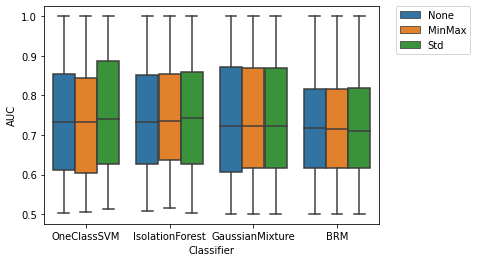

In [ ]:
sns.boxplot(x='Classifier', y='AUC', hue='Normalization', data=models_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
none_df = models_df[models_df.Normalization == 'None']
none_df

,Database,AUC,Normalization,Classifier
0,yeast-2_vs_8,0.577957,None,OneClassSVM
1,zoo-3,0.950000,None,OneClassSVM
2,yeast4,0.758106,None,OneClassSVM
3,yeast1,0.560895,None,OneClassSVM
4,yeast3,0.509757,None,OneClassSVM
...,...,...,...,...
375,abalone-21_vs_8,0.992690,None,BRM
376,abalone-19_vs_10-11-12-13,0.580189,None,BRM
377,abalone-20_vs_8-9-10,0.844577,None,BRM
378,abalone-3_vs_11,0.673469,None,BRM


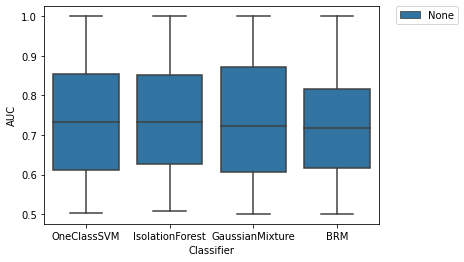

In [ ]:
sns.boxplot(x='Classifier', y='AUC', hue='Normalization', data=none_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
minmax_df = models_df[models_df.Normalization == 'MinMax']
minmax_df

,Database,AUC,Normalization,Classifier
380,yeast-2_vs_8,0.577957,MinMax,OneClassSVM
381,zoo-3,0.950000,MinMax,OneClassSVM
382,yeast4,0.764781,MinMax,OneClassSVM
383,yeast1,0.555274,MinMax,OneClassSVM
384,yeast3,0.515381,MinMax,OneClassSVM
...,...,...,...,...
755,abalone-21_vs_8,0.991228,MinMax,BRM
756,abalone-19_vs_10-11-12-13,0.584232,MinMax,BRM
757,abalone-20_vs_8-9-10,0.841490,MinMax,BRM
758,abalone-3_vs_11,0.697279,MinMax,BRM


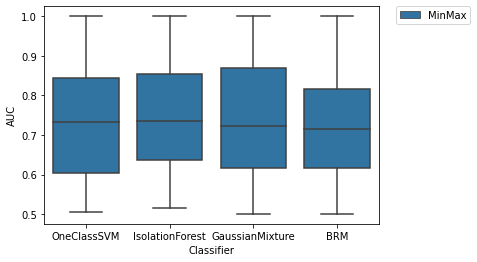

In [ ]:
sns.boxplot(x='Classifier', y='AUC', hue='Normalization', data=minmax_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
std_df = models_df[models_df.Normalization == 'Std']
std_df

,Database,AUC,Normalization,Classifier
760,yeast-2_vs_8,0.626344,Std,OneClassSVM
761,zoo-3,0.900000,Std,OneClassSVM
762,yeast4,0.727908,Std,OneClassSVM
763,yeast1,0.555770,Std,OneClassSVM
764,yeast3,0.521350,Std,OneClassSVM
...,...,...,...,...
1135,abalone-21_vs_8,0.991228,Std,BRM
1136,abalone-19_vs_10-11-12-13,0.580189,Std,BRM
1137,abalone-20_vs_8-9-10,0.845899,Std,BRM
1138,abalone-3_vs_11,0.680272,Std,BRM


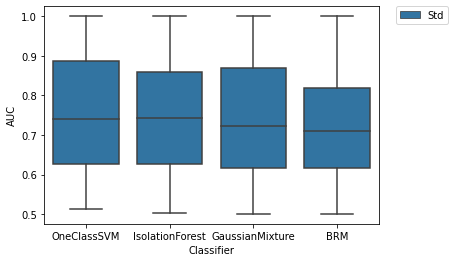

In [ ]:
sns.boxplot(x='Classifier', y='AUC', hue='Normalization', data=std_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [173]:
none_df.describe()

,AUC
count,380.000000
mean,0.739335
std,0.142878
min,0.500654
25%,0.610209
50%,0.724723
75%,0.850000
max,1.000000


In [174]:
minmax_df.describe()

,AUC
count,380.000000
mean,0.740176
std,0.143677
min,0.500654
25%,0.615951
50%,0.728017
75%,0.845762
max,1.000000


In [175]:
std_df.describe()

,AUC
count,380.000000
mean,0.743174
std,0.145341
min,0.500654
25%,0.624758
50%,0.726288
75%,0.854499
max,1.000000


### Normalization: None

#### Friedman's test

In [ ]:
import scipy.stats as st

In [ ]:
# Credits: https://github.com/citiususc/stac/blob/master/stac/nonparametric_tests.py
# Implementation: https://github.com/citiususc/stac/blob/master/stac/unit_tests.py

def friedman_test(*args):
    """
        Performs a Friedman ranking test.
        Tests the hypothesis that in a set of k dependent samples groups (where k >= 2) at least two of the groups represent populations with different median values.
        
        Parameters
        ----------
        sample1, sample2, ... : array_like
            The sample measurements for each group.
            
        Returns
        -------
        F-value : float
            The computed F-value of the test.
        p-value : float
            The associated p-value from the F-distribution.
        rankings : array_like
            The ranking for each group.
        pivots : array_like
            The pivotal quantities for each group.
            
        References
        ----------
        M. Friedman, The use of ranks to avoid the assumption of normality implicit in the analysis of variance, Journal of the American Statistical Association 32 (1937) 674–701.
        D.J. Sheskin, Handbook of parametric and nonparametric statistical procedures. crc Press, 2003, Test 25: The Friedman Two-Way Analysis of Variance by Ranks
    """
    k = len(args)
    if k < 2: raise ValueError('Less than 2 levels')
    n = len(args[0])
    if len(set([len(v) for v in args])) != 1: raise ValueError('Unequal number of samples')

    rankings = []
    for i in range(n):
        row = [col[i] for col in args]
        row_sort = sorted(row)
        rankings.append([row_sort.index(v) + 1 + (row_sort.count(v)-1)/2. for v in row])

    rankings_avg = [np.mean([case[j] for case in rankings]) for j in range(k)]
    rankings_cmp = [r/np.sqrt(k*(k+1)/(6.*n)) for r in rankings_avg]

    chi2 = ((12*n)/float((k*(k+1))))*((np.sum(r**2 for r in rankings_avg))-((k*(k+1)**2)/float(4)))
    iman_davenport = ((n-1)*chi2)/float((n*(k-1)-chi2))

    p_value = 1 - st.f.cdf(iman_davenport, k-1, (k-1)*(n-1))

    return rankings_avg

In [ ]:
classifiers = np.unique(models_df.Classifier)
normalization = np.unique(models_df.Normalization)

In [ ]:
dic = {}

for i in classifiers:
  for j in normalization:
    dic[f'AUC_{i}_{j}'] = models_df[(models_df.Classifier == i) & (models_df.Normalization == j)].AUC.values

final_df = pd.DataFrame(dic)
final_df

,AUC_BRM_MinMax,AUC_BRM_None,AUC_BRM_Std,AUC_GaussianMixture_MinMax,AUC_GaussianMixture_None,AUC_GaussianMixture_Std,AUC_IsolationForest_MinMax,AUC_IsolationForest_None,AUC_IsolationForest_Std,AUC_OneClassSVM_MinMax,AUC_OneClassSVM_None,AUC_OneClassSVM_Std
0,0.629032,0.626344,0.633065,0.647849,0.647849,0.647849,0.596774,0.642473,0.631720,0.577957,0.577957,0.626344
1,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.575000,0.600000,0.625000,0.950000,0.950000,0.900000
2,0.686109,0.689447,0.692467,0.734584,0.734584,0.734584,0.732200,0.724094,0.734743,0.764781,0.758106,0.727908
3,0.529593,0.528629,0.528574,0.552904,0.552904,0.552904,0.551086,0.564615,0.528105,0.555274,0.560895,0.555770
4,0.533173,0.528983,0.533460,0.587810,0.587810,0.587810,0.536616,0.525482,0.550792,0.515381,0.509757,0.521350
...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.991228,0.992690,0.991228,0.985380,0.985380,0.985380,0.941520,0.940058,0.945906,0.891813,0.856725,0.956140
91,0.584232,0.580189,0.580189,0.615903,0.616352,0.615903,0.634322,0.637017,0.630054,0.650943,0.639712,0.561096
92,0.841490,0.844577,0.845899,0.854056,0.854056,0.854056,0.672619,0.650132,0.611552,0.518078,0.503527,0.758818
93,0.697279,0.673469,0.680272,0.982993,0.982993,0.982993,0.993197,0.994898,0.996599,1.000000,0.976190,1.000000


In [ ]:
alpha = 0.05 # significance level

result = st.friedmanchisquare(final_df.AUC_OneClassSVM_None, final_df.AUC_IsolationForest_None, final_df.AUC_GaussianMixture_None, final_df.AUC_BRM_None)
result

FriedmanchisquareResult(statistic=3.599999999999921, pvalue=0.30802217155900236)

In [ ]:
if result.pvalue < alpha:
  print("We can reject the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are not similar statistically. Therefore, we can proceed with a post-hoc test.")
else:
  print("We can accept the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are similar statistically.")

We can accept the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are similar statistically.


In [ ]:
auc_data_none = {
    'AUC_OneClass_SVM_None': final_df.AUC_OneClassSVM_None,
    'AUC_Isolation_Forest_None': final_df.AUC_IsolationForest_None,
    'AUC_Gaussian_Mixture_None': final_df.AUC_GaussianMixture_None,
    'AUC_BRM_None': final_df.AUC_BRM_None,
}

In [ ]:
rankings_avg = friedman_test(*auc_data_none.values())
rankings_avg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


[2.3473684210526318, 2.642105263157895, 2.6, 2.4105263157894736]

#### Post-hoc test

In [ ]:
!pip install scikit-posthocs

     |████████████████████████████████| 43 kB 1.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-posthocs: filename=scikit_posthocs-0.6.7-py3-none-any.whl size=37902 sha256=76d8966b78f54d3806157e55e99794319c3ce69146d18b705a7e329317069466
  Stored in directory: /root/.cache/pip/wheels/b8/21/e6/f39794d4a6ee3d3cc5146ca80b5cd949452ad4a8fde9f6b9fc
Successfully built scikit-posthocs


In [ ]:
import scikit_posthocs as sp

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = np.array([final_df.AUC_OneClassSVM_None, final_df.AUC_IsolationForest_None, final_df.AUC_GaussianMixture_None, final_df.AUC_BRM_None])

In [ ]:
p_values = sp.posthoc_nemenyi_friedman(data.T)
p_values

,0,1,2,3
0,1.000000,0.395067,0.528131,0.900000
1,0.395067,1.000000,0.900000,0.591216
2,0.528131,0.900000,1.000000,0.717386
3,0.900000,0.591216,0.717386,1.000000


In [ ]:
import scipy as scp
import itertools as it

In [ ]:
def _S(k):
    """
        Helper function for the Shaffer test.
        It obtains the number of independent test hypotheses when using an All vs All strategy using the number of groups to be compared.
    """
    if k == 0 or k == 1:
        return {0}
    else:
        result = set()
        for j in reversed(range(1, k+1)):
            tmp = _S(k - j)
            for s in tmp:
                result = result.union({scp.special.binom(j, 2) + s})
        return list(result)


def shaffer_multitest(ranks):
    """
        Performs a Shaffer post-hoc test using the pivot quantities obtained by a ranking test.
        Tests the hypothesis that the ranking of each pair of groups are different.
        
        Parameters
        ----------
        pivots : dictionary_like
            A dictionary with format 'groupname':'pivotal quantity' 
            
        Returns
        ----------
        Comparions : array-like
            Strings identifier of each comparison with format 'group_i vs group_j'
        Z-values : array-like
            The computed Z-value statistic for each comparison.
        p-values : array-like
            The associated p-value from the Z-distribution wich depends on the index of the comparison
        Adjusted p-values : array-like
            The associated adjusted p-values wich can be compared with a significance level
            
        References
        ----------
        J. Li, A two-step rejection procedure for testing multiple hypotheses, Journal of Statistical Planning and Inference 138 (2008) 1521–1527.
    """
    k = len(ranks)
    values = list(ranks.values())
    keys = list(ranks.keys())
    versus = list(it.combinations(range(k), 2))
    
    m = int(k*(k-1)/2.)
    A = _S(int((1 + np.sqrt(1+4*m*2))/2))
    t = [max([a for a in A if a <= m-i]) for i in range(m)]

    comparisons = [keys[vs[0]] + " vs " + keys[vs[1]] for vs in versus]
    z_values = [abs(values[vs[0]] - values[vs[1]]) for vs in versus]
    p_values = [2*(1-st.norm.cdf(abs(z))) for z in z_values]
    # Sort values by p_value so that p_0 < p_1
    p_values, z_values, comparisons = map(list, zip(*sorted(zip(p_values, z_values, comparisons), key=lambda t: t[0])))
    adj_p_values = [min(max(t[j]*p_values[j] for j in range(i+1)), 1) for i in range(m)]
    
    return comparisons, z_values, p_values, adj_p_values

In [ ]:
ranks = {key: rankings_avg[i] for i, key in enumerate(auc_data_none.keys())}
ranks

{'AUC_BRM_None': 2.4105263157894736,
 'AUC_Gaussian_Mixture_None': 2.6,
 'AUC_Isolation_Forest_None': 2.642105263157895,
 'AUC_OneClass_SVM_None': 2.3473684210526318}

In [ ]:
comparisons, z_values, p_values, adj_p_values = shaffer_multitest(ranks)
comparisons, z_values, p_values, adj_p_values

(['AUC_OneClass_SVM_None vs AUC_Isolation_Forest_None',
  'AUC_OneClass_SVM_None vs AUC_Gaussian_Mixture_None',
  'AUC_Isolation_Forest_None vs AUC_BRM_None',
  'AUC_Gaussian_Mixture_None vs AUC_BRM_None',
  'AUC_OneClass_SVM_None vs AUC_BRM_None',
  'AUC_Isolation_Forest_None vs AUC_Gaussian_Mixture_None'],
 [0.2947368421052632,
  0.2526315789473683,
  0.23157894736842133,
  0.18947368421052646,
  0.06315789473684186,
  0.04210526315789487],
 [0.7681949167459463,
  0.800552924922785,
  0.8168650606090959,
  0.8497215784715073,
  0.9496407729386862,
  0.9664147845002375],
 [1, 1, 1, 1, 1, 1])

In [ ]:
def nemenyi_multitest(ranks):
    """
        Performs a Nemenyi post-hoc test using the pivot quantities obtained by a ranking test.
        Tests the hypothesis that the ranking of each pair of groups are different.

        Parameters
        ----------
        pivots : dictionary_like
            A dictionary with format 'groupname':'pivotal quantity' 

        Returns
        ----------
        Comparions : array-like
            Strings identifier of each comparison with format 'group_i vs group_j'
        Z-values : array-like
            The computed Z-value statistic for each comparison.
        p-values : array-like
            The associated p-value from the Z-distribution wich depends on the index of the comparison
        Adjusted p-values : array-like
            The associated adjusted p-values wich can be compared with a significance level

        References
        ----------
        Bonferroni-Dunn: O.J. Dunn, Multiple comparisons among means, Journal of the American Statistical Association 56 (1961) 52–64.
    """
    k = len(ranks)
    values = list(ranks.values())
    keys = list(ranks.keys())
    versus = list(it.combinations(range(k), 2))

    comparisons = [keys[vs[0]] + " vs " + keys[vs[1]] for vs in versus]
    z_values = [abs(values[vs[0]] - values[vs[1]]) for vs in versus]

    p_values = [2 * (1-st.norm.cdf(abs(z))) for z in z_values]
    # Sort values by p_value so that p_0 < p_1
    m = int(k * (k-1)/2.)
    adj_p_values = [min(m*p_value,1) for p_value in p_values]

    return comparisons, z_values, p_values, adj_p_values

In [ ]:
comparisons, z_values, p_values, adj_p_values = nemenyi_multitest(ranks)
comparisons, z_values, p_values, adj_p_values

(['AUC_OneClass_SVM_None vs AUC_Isolation_Forest_None',
  'AUC_OneClass_SVM_None vs AUC_Gaussian_Mixture_None',
  'AUC_OneClass_SVM_None vs AUC_BRM_None',
  'AUC_Isolation_Forest_None vs AUC_Gaussian_Mixture_None',
  'AUC_Isolation_Forest_None vs AUC_BRM_None',
  'AUC_Gaussian_Mixture_None vs AUC_BRM_None'],
 [0.2947368421052632,
  0.2526315789473683,
  0.06315789473684186,
  0.04210526315789487,
  0.23157894736842133,
  0.18947368421052646],
 [0.7681949167459463,
  0.800552924922785,
  0.9496407729386862,
  0.9664147845002375,
  0.8168650606090959,
  0.8497215784715073],
 [1, 1, 1, 1, 1, 1])

#### Critical Difference Diagram

In [ ]:
!pip install Orange3

     |████████████████████████████████| 26.5 MB 86 kB/s 
     |████████████████████████████████| 47 kB 5.4 MB/s 
     |████████████████████████████████| 149 kB 57.0 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
     |████████████████████████████████| 489 kB 61.1 MB/s 
     |████████████████████████████████| 992 kB 59.4 MB/s 
     |████████████████████████████████| 852 kB 59.5 MB/s 
     |████████████████████████████████| 1.0 MB 57.5 MB/s 
     |████████████████████████████████| 8.3 MB 14.9 MB/s 
     |████████████████████████████████| 228 kB 67.8 MB/s 
     |████████████████████████████████| 2.4 MB 21.5 MB/s 
     |████████████████████████████████| 58 kB 7.4 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 78 kB 7.5 MB/s 
     |████████████████████████████████| 51 kB 8.1 MB/s 
     |████████████████████████████████| 59.9 MB 59 kB/s 
     |████████████████████████████████| 317 kB 75.6 MB/s 
     |██████████████████████

In [ ]:
rankings_avg

[2.3473684210526318, 2.642105263157895, 2.6, 2.4105263157894736]

In [ ]:
final_df.shape

(95, 12)

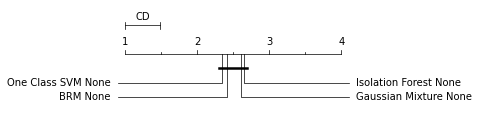

In [ ]:
import Orange

names = ['One Class SVM None', 'Isolation Forest None', 'Gaussian Mixture None', 'BRM None']

avranks = [rankings_avg[0], rankings_avg[1], rankings_avg[2], rankings_avg[3]]

cd = Orange.evaluation.compute_CD(avranks, final_df.shape[0])
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
plt.show();

### Performance evaluation

In [176]:
average_auc = [final_df.AUC_OneClassSVM_None.mean(), final_df.AUC_IsolationForest_None.mean(), final_df.AUC_GaussianMixture_None.mean(), final_df.AUC_BRM_None.mean()]
std_auc = [final_df.AUC_OneClassSVM_None.std(), final_df.AUC_IsolationForest_None.std(), final_df.AUC_GaussianMixture_None.std(), final_df.AUC_BRM_None.std()]

In [180]:
evaluation = pd.DataFrame()
evaluation['Classifier'] = ['One Class SVM None', 'Isolation Forest None', 'Gaussian Mixture None', 'BRM None']
evaluation['Average AUC'] = average_auc
evaluation['STD'] = std_auc
evaluation['Ranking'] = [2.3473684210526318, 2.642105263157895, 2.6, 2.4105263157894736]
evaluation['Adjusted p-value'] = [1, 1, 1, 1]
evaluation.sort_values(by=['Ranking'], inplace=True)
evaluation

,Classifier,Average AUC,STD,Ranking,Adjusted p-value
0,One Class SVM None,0.736568,0.141461,2.347368,1
3,BRM None,0.729249,0.137064,2.410526,1
2,Gaussian Mixture None,0.745060,0.150117,2.600000,1
1,Isolation Forest None,0.746463,0.144152,2.642105,1


### Normalization: MinMax

#### Friedman's test

In [ ]:
alpha = 0.05 # significance level

result = st.friedmanchisquare(final_df.AUC_OneClassSVM_MinMax, final_df.AUC_IsolationForest_MinMax, final_df.AUC_GaussianMixture_MinMax, final_df.AUC_BRM_MinMax)
result

FriedmanchisquareResult(statistic=5.200000000000001, pvalue=0.15772445039666289)

In [ ]:
if result.pvalue < alpha:
  print("We can reject the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are not similar statistically. Therefore, we can proceed with a post-hoc test.")
else:
  print("We can accept the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are similar statistically.")

We can accept the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are similar statistically.


In [ ]:
auc_data_minmax = {
    'AUC_OneClass_SVM_MinMax': final_df.AUC_OneClassSVM_MinMax,
    'AUC_Isolation_Forest_MinMax': final_df.AUC_IsolationForest_MinMax,
    'AUC_Gaussian_Mixture_MinMax': final_df.AUC_GaussianMixture_MinMax,
    'AUC_BRM_MinMax': final_df.AUC_BRM_MinMax,
}

In [ ]:
rankings_avg = friedman_test(*auc_data_minmax.values())
rankings_avg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


[2.278947368421053, 2.6473684210526316, 2.626315789473684, 2.4473684210526314]

#### Post-hoc test

In [ ]:
data = np.array([final_df.AUC_OneClassSVM_MinMax, final_df.AUC_IsolationForest_MinMax, final_df.AUC_GaussianMixture_MinMax, final_df.AUC_BRM_MinMax])

In [ ]:
p_values = sp.posthoc_nemenyi_friedman(data.T)
p_values

,0,1,2,3
0,1.000000,0.200668,0.248011,0.780471
1,0.200668,1.000000,0.900000,0.685841
2,0.248011,0.900000,1.000000,0.748926
3,0.780471,0.685841,0.748926,1.000000


In [ ]:
ranks = {key: rankings_avg[i] for i, key in enumerate(auc_data_minmax.keys())}
ranks

{'AUC_BRM_MinMax': 2.4473684210526314,
 'AUC_Gaussian_Mixture_MinMax': 2.626315789473684,
 'AUC_Isolation_Forest_MinMax': 2.6473684210526316,
 'AUC_OneClass_SVM_MinMax': 2.278947368421053}

In [ ]:
comparisons, z_values, p_values, adj_p_values = shaffer_multitest(ranks)
comparisons, z_values, p_values, adj_p_values

(['AUC_OneClass_SVM_MinMax vs AUC_Isolation_Forest_MinMax',
  'AUC_OneClass_SVM_MinMax vs AUC_Gaussian_Mixture_MinMax',
  'AUC_Isolation_Forest_MinMax vs AUC_BRM_MinMax',
  'AUC_Gaussian_Mixture_MinMax vs AUC_BRM_MinMax',
  'AUC_OneClass_SVM_MinMax vs AUC_BRM_MinMax',
  'AUC_Isolation_Forest_MinMax vs AUC_Gaussian_Mixture_MinMax'],
 [0.36842105263157876,
  0.3473684210526313,
  0.20000000000000018,
  0.17894736842105274,
  0.16842105263157858,
  0.021052631578947434],
 [0.7125593020062799,
  0.7283145543573779,
  0.8414805811217938,
  0.8579790284090667,
  0.8662520470606498,
  0.9832036710341057],
 [1, 1, 1, 1, 1, 1])

In [ ]:
comparisons, z_values, p_values, adj_p_values = nemenyi_multitest(ranks)
comparisons, z_values, p_values, adj_p_values

(['AUC_OneClass_SVM_MinMax vs AUC_Isolation_Forest_MinMax',
  'AUC_OneClass_SVM_MinMax vs AUC_Gaussian_Mixture_MinMax',
  'AUC_OneClass_SVM_MinMax vs AUC_BRM_MinMax',
  'AUC_Isolation_Forest_MinMax vs AUC_Gaussian_Mixture_MinMax',
  'AUC_Isolation_Forest_MinMax vs AUC_BRM_MinMax',
  'AUC_Gaussian_Mixture_MinMax vs AUC_BRM_MinMax'],
 [0.36842105263157876,
  0.3473684210526313,
  0.16842105263157858,
  0.021052631578947434,
  0.20000000000000018,
  0.17894736842105274],
 [0.7125593020062799,
  0.7283145543573779,
  0.8662520470606498,
  0.9832036710341057,
  0.8414805811217938,
  0.8579790284090667],
 [1, 1, 1, 1, 1, 1])

#### Critical Difference Diagram

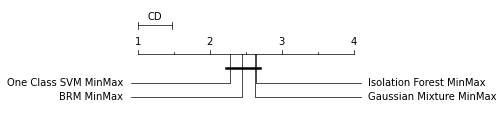

In [ ]:
import Orange

names = ['One Class SVM MinMax', 'Isolation Forest MinMax', 'Gaussian Mixture MinMax', 'BRM MinMax']

avranks = [rankings_avg[0], rankings_avg[1], rankings_avg[2], rankings_avg[3]]

cd = Orange.evaluation.compute_CD(avranks, final_df.shape[0])
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
plt.show();

### Performance evaluation

In [181]:
average_auc = [final_df.AUC_OneClassSVM_MinMax.mean(), final_df.AUC_IsolationForest_MinMax.mean(), final_df.AUC_GaussianMixture_MinMax.mean(), final_df.AUC_BRM_MinMax.mean()]
std_auc = [final_df.AUC_OneClassSVM_MinMax.std(), final_df.AUC_IsolationForest_MinMax.std(), final_df.AUC_GaussianMixture_MinMax.std(), final_df.AUC_BRM_MinMax.std()]

In [183]:
evaluation = pd.DataFrame()
evaluation['Classifier'] = ['One Class SVM MinMax', 'Isolation Forest MinMax', 'Gaussian Mixture MinMax', 'BRM MinMax']
evaluation['Average AUC'] = average_auc
evaluation['STD'] = std_auc
evaluation['Ranking'] = [2.278947368421053, 2.6473684210526316, 2.626315789473684, 2.4473684210526314]
evaluation['Adjusted p-value'] = [1, 1, 1, 1]
evaluation.sort_values(by=['Ranking'], inplace=True)
evaluation

,Classifier,Average AUC,STD,Ranking,Adjusted p-value
0,One Class SVM MinMax,0.734071,0.145566,2.278947,1
3,BRM MinMax,0.730807,0.137279,2.447368,1
2,Gaussian Mixture MinMax,0.744806,0.150099,2.626316,1
1,Isolation Forest MinMax,0.751021,0.142827,2.647368,1


### Normalization: Standard Scaler

#### Friedman's test

In [ ]:
alpha = 0.05 # significance level

result = st.friedmanchisquare(final_df.AUC_OneClassSVM_Std, final_df.AUC_IsolationForest_Std, final_df.AUC_GaussianMixture_Std, final_df.AUC_BRM_Std)
result

FriedmanchisquareResult(statistic=3.436893203883533, pvalue=0.3290395642834584)

In [ ]:
if result.pvalue < alpha:
  print("We can reject the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are not similar statistically. Therefore, we can proceed with a post-hoc test.")
else:
  print("We can accept the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are similar statistically.")

We can accept the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are similar statistically.


In [ ]:
auc_data_std = {
    'AUC_OneClass_SVM_Std': final_df.AUC_OneClassSVM_Std,
    'AUC_Isolation_Forest_Std': final_df.AUC_IsolationForest_Std,
    'AUC_Gaussian_Mixture_Std': final_df.AUC_GaussianMixture_Std,
    'AUC_BRM_Std': final_df.AUC_BRM_Std,
}

In [ ]:
rankings_avg = friedman_test(*auc_data_std.values())
rankings_avg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


[2.5789473684210527, 2.642105263157895, 2.4526315789473685, 2.3263157894736843]

#### Post-hoc test

In [ ]:
data = np.array([final_df.AUC_OneClassSVM_Std, final_df.AUC_IsolationForest_Std, final_df.AUC_GaussianMixture_Std, final_df.AUC_BRM_Std])

In [ ]:
p_values = sp.posthoc_nemenyi_friedman(data.T)
p_values

,0,1,2,3
0,1.000000,0.900000,0.900000,0.528131
1,0.900000,1.000000,0.717386,0.331251
2,0.900000,0.717386,1.000000,0.900000
3,0.528131,0.331251,0.900000,1.000000


In [ ]:
ranks = {key: rankings_avg[i] for i, key in enumerate(auc_data_std.keys())}
ranks

{'AUC_BRM_Std': 2.3263157894736843,
 'AUC_Gaussian_Mixture_Std': 2.4526315789473685,
 'AUC_Isolation_Forest_Std': 2.642105263157895,
 'AUC_OneClass_SVM_Std': 2.5789473684210527}

In [ ]:
comparisons, z_values, p_values, adj_p_values = shaffer_multitest(ranks)
comparisons, z_values, p_values, adj_p_values

(['AUC_Isolation_Forest_Std vs AUC_BRM_Std',
  'AUC_OneClass_SVM_Std vs AUC_BRM_Std',
  'AUC_Isolation_Forest_Std vs AUC_Gaussian_Mixture_Std',
  'AUC_OneClass_SVM_Std vs AUC_Gaussian_Mixture_Std',
  'AUC_Gaussian_Mixture_Std vs AUC_BRM_Std',
  'AUC_OneClass_SVM_Std vs AUC_Isolation_Forest_Std'],
 [0.3157894736842106,
  0.2526315789473683,
  0.18947368421052646,
  0.12631578947368416,
  0.12631578947368416,
  0.0631578947368423],
 [0.7521623083780538,
  0.800552924922785,
  0.8497215784715073,
  0.899481958176398,
  0.899481958176398,
  0.949640772938686],
 [1, 1, 1, 1, 1, 1])

In [ ]:
comparisons, z_values, p_values, adj_p_values = nemenyi_multitest(ranks)
comparisons, z_values, p_values, adj_p_values

(['AUC_OneClass_SVM_Std vs AUC_Isolation_Forest_Std',
  'AUC_OneClass_SVM_Std vs AUC_Gaussian_Mixture_Std',
  'AUC_OneClass_SVM_Std vs AUC_BRM_Std',
  'AUC_Isolation_Forest_Std vs AUC_Gaussian_Mixture_Std',
  'AUC_Isolation_Forest_Std vs AUC_BRM_Std',
  'AUC_Gaussian_Mixture_Std vs AUC_BRM_Std'],
 [0.0631578947368423,
  0.12631578947368416,
  0.2526315789473683,
  0.18947368421052646,
  0.3157894736842106,
  0.12631578947368416],
 [0.949640772938686,
  0.899481958176398,
  0.800552924922785,
  0.8497215784715073,
  0.7521623083780538,
  0.899481958176398],
 [1, 1, 1, 1, 1, 1])

#### Critical Difference Diagram

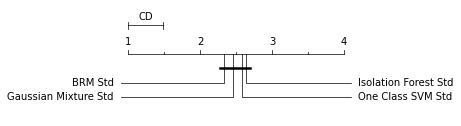

In [ ]:
import Orange

names = ['One Class SVM Std', 'Isolation Forest Std', 'Gaussian Mixture Std', 'BRM Std']

avranks = [rankings_avg[0], rankings_avg[1], rankings_avg[2], rankings_avg[3]]

cd = Orange.evaluation.compute_CD(avranks, final_df.shape[0])
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
plt.show();

### Performance Evaluation

In [184]:
average_auc = [final_df.AUC_OneClassSVM_Std.mean(), final_df.AUC_IsolationForest_Std.mean(), final_df.AUC_GaussianMixture_Std.mean(), final_df.AUC_BRM_Std.mean()]
std_auc = [final_df.AUC_OneClassSVM_Std.std(), final_df.AUC_IsolationForest_Std.std(), final_df.AUC_GaussianMixture_Std.std(), final_df.AUC_BRM_Std.std()]

In [185]:
evaluation = pd.DataFrame()
evaluation['Classifier'] = ['One Class SVM Std', 'Isolation Forest Std', 'Gaussian Mixture Std', 'BRM Std']
evaluation['Average AUC'] = average_auc
evaluation['STD'] = std_auc
evaluation['Ranking'] = [2.5789473684210527, 2.642105263157895, 2.4526315789473685, 2.3263157894736843]
evaluation['Adjusted p-value'] = [1, 1, 1, 1]
evaluation.sort_values(by=['Ranking'], inplace=True)
evaluation

,Classifier,Average AUC,STD,Ranking,Adjusted p-value
3,BRM Std,0.729811,0.137715,2.326316,1
2,Gaussian Mixture Std,0.744744,0.149977,2.452632,1
0,One Class SVM Std,0.745807,0.151697,2.578947,1
1,Isolation Forest Std,0.752336,0.142917,2.642105,1


## Custom BRM

In [ ]:
import numpy as np
import math
import os
import random
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity, linear_kernel
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class BRM_Custom(BRM):
    def __init__(self, classifier_count=100, bootstrap_sample_percent=100, use_bootstrap_sample_count=False, bootstrap_sample_count=0, use_past_even_queue=False, max_event_count=3, alpha=0.5, user_threshold=95, dissimilarity_measure='euclidean'):
        self.classifier_count = classifier_count
        self.bootstrap_sample_percent = bootstrap_sample_percent
        self.use_bootstrap_sample_count = use_bootstrap_sample_count
        self.bootstrap_sample_count = bootstrap_sample_count
        self.use_past_even_queue = use_past_even_queue
        self.max_event_count = max_event_count
        self.alpha = alpha
        self.user_threshold = user_threshold
        self.dissimilarity_measure = dissimilarity_measure

    def get_distance(self,a,b):
        if self.dissimilarity_measure == 'manhattan':
            return manhattan_distances(a,b)
        if self.dissimilarity_measure == 'cosine':
            return cosine_similarity(a,b)
        if self.dissimilarity_measure == 'linear':
            return linear_kernel(a,b)
        return euclidean_distances(a,b)

    def score_samples(self, X):
        X = np.array(X)
        X_test = self._scaler.transform(X)

        result = []
        batch_size = 100
        for i in range(min(len(X_test), batch_size), len(X_test) + batch_size, batch_size):
            current_X_test = X_test[[j for j in range(max(0, i-batch_size), min(i, len(X_test)))]]

            current_similarity = np.average([np.exp(-np.power(np.amin(self.get_distance(current_X_test, self._centers[i]), axis=1)/self._max_dissimilarity, 2)/(self._sd[i])) for i in range(len(self._centers))], axis=0)
        
            result = result + [j for j in list(map(self._evaluate, current_similarity))]

        return result

    def fit(self, X, y = None):
        # Check that X and y have correct shape
        if y is not None:
            X_train, y_train = check_X_y(X, y)
        else:
             X_train = check_array(X)
             
        self._similarity_sum = 0
        self._is_threshold_Computed = False

        self.n_features_in_ = X_train.shape[1]

        if self.n_features_in_ < 1:
            raise ValueError('Unable to instantiate the train dataset - Empty vector')     
        
        self._scaler = MinMaxScaler()
        X_train = pd.DataFrame(X_train)
        X_train = pd.DataFrame(self._scaler.fit_transform(X_train[X_train.columns]), index=X_train.index, columns=X_train.columns)


        self._max_dissimilarity = math.sqrt(self.n_features_in_)
        self._sd = np.empty(0)
        sampleSize = int(self.bootstrap_sample_count) if (self.use_bootstrap_sample_count) else int(0.01 * self.bootstrap_sample_percent * len(X_train));
        self._centers = np.empty((0, sampleSize, self.n_features_in_))

        list_instances = X_train.values.tolist()
        for i in range(0, self.classifier_count):            
            centers = random.choices(list_instances, k=sampleSize)
            self._centers = np.insert(self._centers, i, centers, axis=0)
            self._sd = np.insert(self._sd, i, 2*(np.mean(self.get_distance(centers, centers))/self._max_dissimilarity)**2)

        return self

### Custom BRM with at least three dissimilarity measures.

In [ ]:
apply_classifier(rootDir, BRM_Custom, 'BRMCustom', normalization='Std')

Implementing BRMCustom ...
BRMCustom implemented


In [ ]:
apply_classifier(rootDir, BRM_Custom, 'BRMCustom', normalization='Std', brm_custom_dissimilarity_measure='manhattan')

Implementing BRMCustom ...
BRMCustom implemented


In [ ]:
apply_classifier(rootDir, BRM_Custom, 'BRMCustom', normalization='Std', brm_custom_dissimilarity_measure='cosine')

Implementing BRMCustom ...
BRMCustom implemented


In [ ]:
apply_classifier(rootDir, BRM_Custom, 'BRMCustom', normalization='Std', brm_custom_dissimilarity_measure='linear')

Implementing BRMCustom ...
BRMCustom implemented


In [ ]:
brm_custom_euclidean = pd.read_csv(rootDir + 'BRMCustom_Std_results.csv', index_col=0)
brm_custom_manhattan = pd.read_csv(rootDir + 'BRMCustom_Std_manhattan_results.csv', index_col=0)
brm_custom_cosine = pd.read_csv(rootDir + 'BRMCustom_Std_cosine_results.csv', index_col=0)
brm_custom_linear = pd.read_csv(rootDir + 'BRMCustom_Std_linear_results.csv', index_col=0)

In [ ]:
brm_custom_std = brm_custom_euclidean
brm_custom_std.rename(columns={'AUC': 'AUC_Euclidean'}, inplace=True)
brm_custom_std['AUC_Manhattan'] = brm_custom_manhattan.AUC
brm_custom_std['AUC_Cosine'] = brm_custom_cosine.AUC
brm_custom_std['AUC_Linear'] = brm_custom_linear.AUC
brm_custom_std

,Database,AUC_Euclidean,AUC_Manhattan,AUC_Cosine,AUC_Linear
0,yeast-2_vs_8,0.631720,0.629032,0.672043,0.514785
1,zoo-3,0.600000,0.675000,0.950000,0.850000
2,yeast4,0.686586,0.663859,0.829943,0.676573
3,yeast1,0.526976,0.545437,0.630222,0.505897
4,yeast3,0.530073,0.522153,0.869490,0.842746
...,...,...,...,...,...
90,abalone-21_vs_8,0.989766,0.994152,0.584795,0.530702
91,abalone-19_vs_10-11-12-13,0.589847,0.566936,0.640162,0.636343
92,abalone-20_vs_8-9-10,0.844577,0.852072,0.503307,0.584215
93,abalone-3_vs_11,0.676871,0.714286,0.998299,1.000000


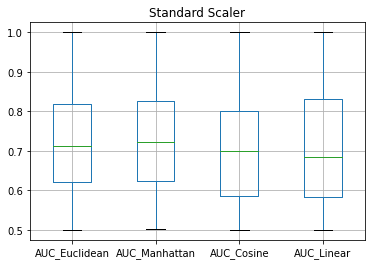

In [ ]:
brm_custom_std.boxplot(column=['AUC_Euclidean', 'AUC_Manhattan', 'AUC_Cosine', 'AUC_Linear'])
plt.title('Standard Scaler')
plt.show();

## Algorithms + Databases + Statistical Tests + Visualizations + Data Transformation + Dissimilarity measure

### Normalization: None

In [ ]:
apply_classifier(rootDir, BRM_Custom, 'BRMCustom')

Implementing BRMCustom ...
BRMCustom implemented


In [ ]:
apply_classifier(rootDir, BRM_Custom, 'BRMCustom', brm_custom_dissimilarity_measure='manhattan')

Implementing BRMCustom ...
BRMCustom implemented


In [ ]:
apply_classifier(rootDir, BRM_Custom, 'BRMCustom', brm_custom_dissimilarity_measure='cosine')

Implementing BRMCustom ...
BRMCustom implemented


In [ ]:
apply_classifier(rootDir, BRM_Custom, 'BRMCustom', brm_custom_dissimilarity_measure='linear')

Implementing BRMCustom ...
BRMCustom implemented


In [198]:
evaluation = pd.DataFrame()
evaluation['BRMCustom_Euclidean_None'] = brm_custom_euclidean_none.AUC
evaluation['BRMCustom_Manhattan_None'] = brm_custom_manhattan_none.AUC
evaluation['BRMCustom_Cosine_None'] = brm_custom_cosine_none.AUC
evaluation['BRMCustom_Linear_None'] = brm_custom_linear_none.AUC
evaluation

,BRMCustom_Euclidean_None,BRMCustom_Manhattan_None,BRMCustom_Cosine_None,BRMCustom_Linear_None
0,0.629032,0.627688,0.665323,0.514785
1,0.600000,0.675000,0.950000,0.850000
2,0.692149,0.669580,0.822314,0.676891
3,0.526976,0.545657,0.630938,0.507274
4,0.532140,0.520202,0.870351,0.839474
...,...,...,...,...
90,0.992690,0.991228,0.589181,0.514620
91,0.587601,0.566712,0.640836,0.634546
92,0.845679,0.853836,0.518078,0.590608
93,0.673469,0.709184,1.000000,1.000000


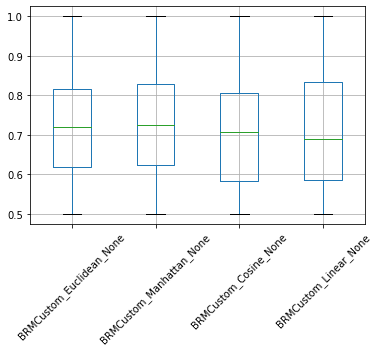

In [202]:
evaluation.boxplot()
plt.xticks(rotation=45);

#### Friedman's test

In [ ]:
brm_custom_euclidean_none = pd.read_csv(rootDir + 'BRMCustom_None_euclidean_results.csv', index_col=0)
brm_custom_manhattan_none = pd.read_csv(rootDir + 'BRMCustom_None_manhattan_results.csv', index_col=0)
brm_custom_cosine_none = pd.read_csv(rootDir + 'BRMCustom_None_cosine_results.csv', index_col=0)
brm_custom_linear_none = pd.read_csv(rootDir + 'BRMCustom_None_linear_results.csv', index_col=0)

In [ ]:
alpha = 0.05 # significance level

result = st.friedmanchisquare(final_df.AUC_OneClassSVM_None, final_df.AUC_IsolationForest_None, final_df.AUC_GaussianMixture_None, brm_custom_euclidean_none.AUC,
                              brm_custom_manhattan_none.AUC, brm_custom_cosine_none.AUC, brm_custom_linear_none.AUC)
result

FriedmanchisquareResult(statistic=7.262021961378392, pvalue=0.29729391018232243)

In [ ]:
if result.pvalue < alpha:
  print("We can reject the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are not similar statistically. Therefore, we can proceed with a post-hoc test.")
else:
  print("We can accept the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are similar statistically.")

We can accept the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are similar statistically.


In [ ]:
auc_data_none = {
    'AUC_OneClass_SVM_None': final_df.AUC_OneClassSVM_None,
    'AUC_Isolation_Forest_None': final_df.AUC_IsolationForest_None,
    'AUC_Gaussian_Mixture_None': final_df.AUC_GaussianMixture_None,
    'AUC_BRM_None': brm_custom_euclidean_none.AUC,
    'AUC_BRM_Manhattan_None': brm_custom_manhattan_none.AUC,
    'AUC_BRM_Cosine_None': brm_custom_cosine_none.AUC,
    'AUC_BRM_Linear_None': brm_custom_linear_none.AUC,
}

In [ ]:
rankings_avg = friedman_test(*auc_data_none.values())
rankings_avg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


[3.963157894736842,
 4.457894736842105,
 4.121052631578947,
 3.836842105263158,
 4.005263157894737,
 3.9263157894736844,
 3.6894736842105265]

#### Post-hoc test

In [ ]:
data = []

for key, values in auc_data_none.items():
    data.append(values)

data = np.array(data)

In [ ]:
p_values = sp.posthoc_nemenyi_friedman(data.T)
p_values

,0,1,2,3,4,5,6
0,1.000000,0.671378,0.900000,0.900000,0.900000,0.900000,0.900000
1,0.671378,1.000000,0.900000,0.428876,0.750367,0.602262,0.177117
2,0.900000,0.900000,1.000000,0.900000,0.900000,0.900000,0.789862
3,0.900000,0.428876,0.900000,1.000000,0.900000,0.900000,0.900000
4,0.900000,0.750367,0.900000,0.900000,1.000000,0.900000,0.900000
5,0.900000,0.602262,0.900000,0.900000,0.900000,1.000000,0.900000
6,0.900000,0.177117,0.789862,0.900000,0.900000,0.900000,1.000000


In [ ]:
ranks = {key: rankings_avg[i] for i, key in enumerate(auc_data_none.keys())}
ranks

{'AUC_BRM_Cosine_None': 3.9263157894736844,
 'AUC_BRM_Linear_None': 3.6894736842105265,
 'AUC_BRM_Manhattan_None': 4.005263157894737,
 'AUC_BRM_None': 3.836842105263158,
 'AUC_Gaussian_Mixture_None': 4.121052631578947,
 'AUC_Isolation_Forest_None': 4.457894736842105,
 'AUC_OneClass_SVM_None': 3.963157894736842}

In [ ]:
comparisons, z_values, p_values, adj_p_values = shaffer_multitest(ranks)
comparisons, z_values, p_values, adj_p_values

(['AUC_Isolation_Forest_None vs AUC_BRM_Linear_None',
  'AUC_Isolation_Forest_None vs AUC_BRM_None',
  'AUC_Isolation_Forest_None vs AUC_BRM_Cosine_None',
  'AUC_OneClass_SVM_None vs AUC_Isolation_Forest_None',
  'AUC_Isolation_Forest_None vs AUC_BRM_Manhattan_None',
  'AUC_Gaussian_Mixture_None vs AUC_BRM_Linear_None',
  'AUC_Isolation_Forest_None vs AUC_Gaussian_Mixture_None',
  'AUC_BRM_Manhattan_None vs AUC_BRM_Linear_None',
  'AUC_Gaussian_Mixture_None vs AUC_BRM_None',
  'AUC_OneClass_SVM_None vs AUC_BRM_Linear_None',
  'AUC_BRM_Cosine_None vs AUC_BRM_Linear_None',
  'AUC_Gaussian_Mixture_None vs AUC_BRM_Cosine_None',
  'AUC_BRM_None vs AUC_BRM_Manhattan_None',
  'AUC_OneClass_SVM_None vs AUC_Gaussian_Mixture_None',
  'AUC_BRM_None vs AUC_BRM_Linear_None',
  'AUC_OneClass_SVM_None vs AUC_BRM_None',
  'AUC_Gaussian_Mixture_None vs AUC_BRM_Manhattan_None',
  'AUC_BRM_None vs AUC_BRM_Cosine_None',
  'AUC_BRM_Manhattan_None vs AUC_BRM_Cosine_None',
  'AUC_OneClass_SVM_None vs AUC_BRM

In [ ]:
comparisons, z_values, p_values, adj_p_values = nemenyi_multitest(ranks)
comparisons, z_values, p_values, adj_p_values

(['AUC_OneClass_SVM_None vs AUC_Isolation_Forest_None',
  'AUC_OneClass_SVM_None vs AUC_Gaussian_Mixture_None',
  'AUC_OneClass_SVM_None vs AUC_BRM_None',
  'AUC_OneClass_SVM_None vs AUC_BRM_Manhattan_None',
  'AUC_OneClass_SVM_None vs AUC_BRM_Cosine_None',
  'AUC_OneClass_SVM_None vs AUC_BRM_Linear_None',
  'AUC_Isolation_Forest_None vs AUC_Gaussian_Mixture_None',
  'AUC_Isolation_Forest_None vs AUC_BRM_None',
  'AUC_Isolation_Forest_None vs AUC_BRM_Manhattan_None',
  'AUC_Isolation_Forest_None vs AUC_BRM_Cosine_None',
  'AUC_Isolation_Forest_None vs AUC_BRM_Linear_None',
  'AUC_Gaussian_Mixture_None vs AUC_BRM_None',
  'AUC_Gaussian_Mixture_None vs AUC_BRM_Manhattan_None',
  'AUC_Gaussian_Mixture_None vs AUC_BRM_Cosine_None',
  'AUC_Gaussian_Mixture_None vs AUC_BRM_Linear_None',
  'AUC_BRM_None vs AUC_BRM_Manhattan_None',
  'AUC_BRM_None vs AUC_BRM_Cosine_None',
  'AUC_BRM_None vs AUC_BRM_Linear_None',
  'AUC_BRM_Manhattan_None vs AUC_BRM_Cosine_None',
  'AUC_BRM_Manhattan_None vs AU

### Critical Difference Diagram

In [ ]:
names = []

for key, values in auc_data_none.items():
    names.append(key)

avranks = []
for i in rankings_avg:
  avranks.append(i)

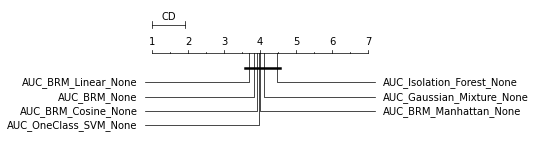

In [ ]:
import Orange

cd = Orange.evaluation.compute_CD(avranks, final_df.shape[0])
Orange.evaluation.graph_ranks(np.array(avranks), np.array(names), cd=cd, width=6, textspace=1.5)
plt.show();

### Normalization: MinMax

In [ ]:
apply_classifier(rootDir, BRM_Custom, 'BRMCustom', normalization='MinMax')

Implementing BRMCustom ...
BRMCustom implemented


In [ ]:
apply_classifier(rootDir, BRM_Custom, 'BRMCustom', normalization='MinMax', brm_custom_dissimilarity_measure='manhattan')

Implementing BRMCustom ...
BRMCustom implemented


In [ ]:
apply_classifier(rootDir, BRM_Custom, 'BRMCustom', normalization='MinMax', brm_custom_dissimilarity_measure='cosine')

Implementing BRMCustom ...
BRMCustom implemented


In [ ]:
apply_classifier(rootDir, BRM_Custom, 'BRMCustom', normalization='MinMax', brm_custom_dissimilarity_measure='linear')

Implementing BRMCustom ...
BRMCustom implemented


In [203]:
evaluation = pd.DataFrame()
evaluation['BRMCustom_Euclidean_MinMax'] = brm_custom_euclidean_minmax.AUC
evaluation['BRMCustom_Manhattan_MinMax'] = brm_custom_manhattan_minmax.AUC
evaluation['BRMCustom_Cosine_MinMax'] = brm_custom_cosine_minmax.AUC
evaluation['BRMCustom_Linear_MinMax'] = brm_custom_linear_minmax.AUC
evaluation

,BRMCustom_Euclidean_MinMax,BRMCustom_Manhattan_MinMax,BRMCustom_Cosine_MinMax,BRMCustom_Linear_MinMax
0,0.626344,0.631720,0.672043,0.516129
1,0.575000,0.700000,0.950000,0.850000
2,0.682613,0.668627,0.823109,0.680229
3,0.527279,0.543205,0.637827,0.506861
4,0.534780,0.523875,0.880337,0.840909
...,...,...,...,...
90,0.991228,0.994152,0.584795,0.513158
91,0.592767,0.577044,0.644654,0.635669
92,0.847884,0.854497,0.508157,0.587522
93,0.688776,0.702381,0.989796,0.998299


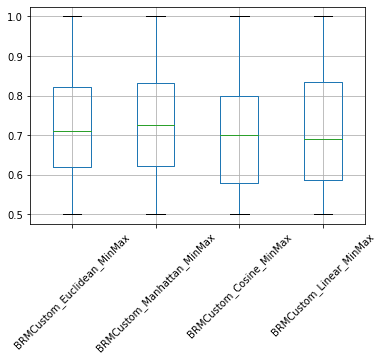

In [204]:
evaluation.boxplot()
plt.xticks(rotation=45);

#### Friedman's Test

In [ ]:
brm_custom_euclidean_minmax = pd.read_csv(rootDir + 'BRMCustom_MinMax_euclidean_results.csv', index_col=0)
brm_custom_manhattan_minmax = pd.read_csv(rootDir + 'BRMCustom_MinMax_manhattan_results.csv', index_col=0)
brm_custom_cosine_minmax = pd.read_csv(rootDir + 'BRMCustom_MinMax_cosine_results.csv', index_col=0)
brm_custom_linear_minmax = pd.read_csv(rootDir + 'BRMCustom_MinMax_linear_results.csv', index_col=0)

In [ ]:
alpha = 0.05 # significance level

result = st.friedmanchisquare(final_df.AUC_OneClassSVM_MinMax, final_df.AUC_IsolationForest_MinMax, final_df.AUC_GaussianMixture_MinMax, brm_custom_euclidean_minmax.AUC,
                              brm_custom_manhattan_minmax.AUC, brm_custom_cosine_minmax.AUC, brm_custom_linear_minmax.AUC)
result

FriedmanchisquareResult(statistic=8.56931818181811, pvalue=0.1992869836178508)

In [ ]:
if result.pvalue < alpha:
  print("We can reject the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are not similar statistically. Therefore, we can proceed with a post-hoc test.")
else:
  print("We can accept the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are similar statistically.")

We can accept the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are similar statistically.


In [ ]:
auc_data_minmax = {
    'AUC_OneClass_SVM_MinMax': final_df.AUC_OneClassSVM_MinMax,
    'AUC_Isolation_Forest_MinMax': final_df.AUC_IsolationForest_MinMax,
    'AUC_Gaussian_Mixture_MinMax': final_df.AUC_GaussianMixture_MinMax,
    'AUC_BRM_MinMax': brm_custom_euclidean_minmax.AUC,
    'AUC_BRM_Manhattan_MinMax': brm_custom_manhattan_minmax.AUC,
    'AUC_BRM_Cosine_MinMax': brm_custom_cosine_minmax.AUC,
    'AUC_BRM_Linear_MinMax': brm_custom_linear_minmax.AUC,
}

In [ ]:
rankings_avg = friedman_test(*auc_data_minmax.values())
rankings_avg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


[3.9263157894736844,
 4.442105263157894,
 4.252631578947368,
 3.931578947368421,
 3.968421052631579,
 3.8157894736842106,
 3.663157894736842]

#### Post-hoc test

In [ ]:
data = []

for key, values in auc_data_minmax.items():
    data.append(values)

data = np.array(data)

In [ ]:
p_values = sp.posthoc_nemenyi_friedman(data.T)
p_values

,0,1,2,3,4,5,6
0,1.000000,0.631881,0.900000,0.900000,0.900000,0.900000,0.900000
1,0.631881,1.000000,0.900000,0.641755,0.710872,0.417978,0.164678
2,0.900000,0.900000,1.000000,0.900000,0.900000,0.779989,0.493303
3,0.900000,0.641755,0.900000,1.000000,0.900000,0.900000,0.900000
4,0.900000,0.710872,0.900000,0.900000,1.000000,0.900000,0.900000
5,0.900000,0.417978,0.779989,0.900000,0.900000,1.000000,0.900000
6,0.900000,0.164678,0.493303,0.900000,0.900000,0.900000,1.000000


In [ ]:
ranks = {key: rankings_avg[i] for i, key in enumerate(auc_data_minmax.keys())}
ranks

{'AUC_BRM_Cosine_MinMax': 3.8157894736842106,
 'AUC_BRM_Linear_MinMax': 3.663157894736842,
 'AUC_BRM_Manhattan_MinMax': 3.968421052631579,
 'AUC_BRM_MinMax': 3.931578947368421,
 'AUC_Gaussian_Mixture_MinMax': 4.252631578947368,
 'AUC_Isolation_Forest_MinMax': 4.442105263157894,
 'AUC_OneClass_SVM_MinMax': 3.9263157894736844}

In [ ]:
comparisons, z_values, p_values, adj_p_values = shaffer_multitest(ranks)
comparisons, z_values, p_values, adj_p_values

(['AUC_Isolation_Forest_MinMax vs AUC_BRM_Linear_MinMax',
  'AUC_Isolation_Forest_MinMax vs AUC_BRM_Cosine_MinMax',
  'AUC_Gaussian_Mixture_MinMax vs AUC_BRM_Linear_MinMax',
  'AUC_OneClass_SVM_MinMax vs AUC_Isolation_Forest_MinMax',
  'AUC_Isolation_Forest_MinMax vs AUC_BRM_MinMax',
  'AUC_Isolation_Forest_MinMax vs AUC_BRM_Manhattan_MinMax',
  'AUC_Gaussian_Mixture_MinMax vs AUC_BRM_Cosine_MinMax',
  'AUC_OneClass_SVM_MinMax vs AUC_Gaussian_Mixture_MinMax',
  'AUC_Gaussian_Mixture_MinMax vs AUC_BRM_MinMax',
  'AUC_BRM_Manhattan_MinMax vs AUC_BRM_Linear_MinMax',
  'AUC_Gaussian_Mixture_MinMax vs AUC_BRM_Manhattan_MinMax',
  'AUC_BRM_MinMax vs AUC_BRM_Linear_MinMax',
  'AUC_OneClass_SVM_MinMax vs AUC_BRM_Linear_MinMax',
  'AUC_Isolation_Forest_MinMax vs AUC_Gaussian_Mixture_MinMax',
  'AUC_BRM_Cosine_MinMax vs AUC_BRM_Linear_MinMax',
  'AUC_BRM_Manhattan_MinMax vs AUC_BRM_Cosine_MinMax',
  'AUC_BRM_MinMax vs AUC_BRM_Cosine_MinMax',
  'AUC_OneClass_SVM_MinMax vs AUC_BRM_Cosine_MinMax',


In [ ]:
comparisons, z_values, p_values, adj_p_values = nemenyi_multitest(ranks)
comparisons, z_values, p_values, adj_p_values

(['AUC_OneClass_SVM_MinMax vs AUC_Isolation_Forest_MinMax',
  'AUC_OneClass_SVM_MinMax vs AUC_Gaussian_Mixture_MinMax',
  'AUC_OneClass_SVM_MinMax vs AUC_BRM_MinMax',
  'AUC_OneClass_SVM_MinMax vs AUC_BRM_Manhattan_MinMax',
  'AUC_OneClass_SVM_MinMax vs AUC_BRM_Cosine_MinMax',
  'AUC_OneClass_SVM_MinMax vs AUC_BRM_Linear_MinMax',
  'AUC_Isolation_Forest_MinMax vs AUC_Gaussian_Mixture_MinMax',
  'AUC_Isolation_Forest_MinMax vs AUC_BRM_MinMax',
  'AUC_Isolation_Forest_MinMax vs AUC_BRM_Manhattan_MinMax',
  'AUC_Isolation_Forest_MinMax vs AUC_BRM_Cosine_MinMax',
  'AUC_Isolation_Forest_MinMax vs AUC_BRM_Linear_MinMax',
  'AUC_Gaussian_Mixture_MinMax vs AUC_BRM_MinMax',
  'AUC_Gaussian_Mixture_MinMax vs AUC_BRM_Manhattan_MinMax',
  'AUC_Gaussian_Mixture_MinMax vs AUC_BRM_Cosine_MinMax',
  'AUC_Gaussian_Mixture_MinMax vs AUC_BRM_Linear_MinMax',
  'AUC_BRM_MinMax vs AUC_BRM_Manhattan_MinMax',
  'AUC_BRM_MinMax vs AUC_BRM_Cosine_MinMax',
  'AUC_BRM_MinMax vs AUC_BRM_Linear_MinMax',
  'AUC_BRM

#### Critical Difference Diagram

In [ ]:
names = []

for key, values in auc_data_minmax.items():
    names.append(key)

In [ ]:
avranks = []
for i in rankings_avg:
  avranks.append(i)

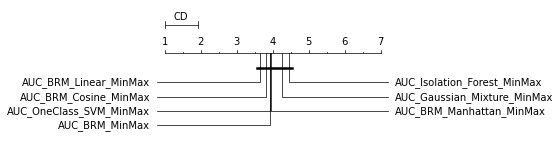

In [ ]:
import Orange

cd = Orange.evaluation.compute_CD(avranks, final_df.shape[0])
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
plt.show();

### Normalization: Standard Scaler

In [ ]:
alpha = 0.05 # significance level

result = st.friedmanchisquare(final_df.AUC_OneClassSVM_Std, final_df.AUC_IsolationForest_Std, final_df.AUC_GaussianMixture_Std, brm_custom_euclidean.AUC_Euclidean,
                              brm_custom_manhattan.AUC, brm_custom_cosine.AUC, brm_custom_linear.AUC)
result

FriedmanchisquareResult(statistic=9.772796352583846, pvalue=0.13455192589699091)

In [ ]:
if result.pvalue < alpha:
  print("We can reject the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are not similar statistically. Therefore, we can proceed with a post-hoc test.")
else:
  print("We can accept the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are similar statistically.")

We can accept the null hypothesis: so the results obtained by all the tested classifiers, in all the databases, are similar statistically.


In [ ]:
auc_data_std = {
    'AUC_OneClass_SVM_Std': final_df.AUC_OneClassSVM_Std,
    'AUC_Isolation_Forest_Std': final_df.AUC_IsolationForest_Std,
    'AUC_Gaussian_Mixture_Std': final_df.AUC_GaussianMixture_Std,
    'AUC_BRM_Std': brm_custom_euclidean.AUC_Euclidean,
    'AUC_BRM_Manhattan_Std': brm_custom_manhattan.AUC,
    'AUC_BRM_Cosine_Std': brm_custom_cosine.AUC,
    'AUC_BRM_Linear_Std': brm_custom_linear.AUC,
}

In [ ]:
rankings_avg = friedman_test(*auc_data_std.values())
rankings_avg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


[4.2631578947368425,
 4.442105263157894,
 4.026315789473684,
 3.7842105263157895,
 4.010526315789473,
 3.8473684210526318,
 3.626315789473684]

#### Post-hoc test

In [ ]:
data = []

for key, values in auc_data_std.items():
    data.append(values)

data = np.array(data)

In [ ]:
p_values = sp.posthoc_nemenyi_friedman(data.T)
p_values

,0,1,2,3,4,5,6
0,1.000000,0.900000,0.900000,0.700997,0.900000,0.819481,0.396247
1,0.900000,1.000000,0.819481,0.353747,0.789862,0.482786,0.124997
2,0.900000,0.819481,1.000000,0.900000,0.900000,0.900000,0.849102
3,0.700997,0.353747,0.900000,1.000000,0.900000,0.900000,0.900000
4,0.900000,0.789862,0.900000,0.900000,1.000000,0.900000,0.878724
5,0.819481,0.482786,0.900000,0.900000,0.900000,1.000000,0.900000
6,0.396247,0.124997,0.849102,0.900000,0.878724,0.900000,1.000000


In [ ]:
ranks = {key: rankings_avg[i] for i, key in enumerate(auc_data_std.keys())}
ranks

{'AUC_BRM_Cosine_Std': 3.8473684210526318,
 'AUC_BRM_Linear_Std': 3.626315789473684,
 'AUC_BRM_Manhattan_Std': 4.010526315789473,
 'AUC_BRM_Std': 3.7842105263157895,
 'AUC_Gaussian_Mixture_Std': 4.026315789473684,
 'AUC_Isolation_Forest_Std': 4.442105263157894,
 'AUC_OneClass_SVM_Std': 4.2631578947368425}

In [ ]:
comparisons, z_values, p_values, adj_p_values = shaffer_multitest(ranks)
comparisons, z_values, p_values, adj_p_values

(['AUC_Isolation_Forest_Std vs AUC_BRM_Linear_Std',
  'AUC_Isolation_Forest_Std vs AUC_BRM_Std',
  'AUC_OneClass_SVM_Std vs AUC_BRM_Linear_Std',
  'AUC_Isolation_Forest_Std vs AUC_BRM_Cosine_Std',
  'AUC_OneClass_SVM_Std vs AUC_BRM_Std',
  'AUC_Isolation_Forest_Std vs AUC_BRM_Manhattan_Std',
  'AUC_OneClass_SVM_Std vs AUC_BRM_Cosine_Std',
  'AUC_Isolation_Forest_Std vs AUC_Gaussian_Mixture_Std',
  'AUC_Gaussian_Mixture_Std vs AUC_BRM_Linear_Std',
  'AUC_BRM_Manhattan_Std vs AUC_BRM_Linear_Std',
  'AUC_OneClass_SVM_Std vs AUC_BRM_Manhattan_Std',
  'AUC_Gaussian_Mixture_Std vs AUC_BRM_Std',
  'AUC_OneClass_SVM_Std vs AUC_Gaussian_Mixture_Std',
  'AUC_BRM_Std vs AUC_BRM_Manhattan_Std',
  'AUC_BRM_Cosine_Std vs AUC_BRM_Linear_Std',
  'AUC_Gaussian_Mixture_Std vs AUC_BRM_Cosine_Std',
  'AUC_OneClass_SVM_Std vs AUC_Isolation_Forest_Std',
  'AUC_BRM_Manhattan_Std vs AUC_BRM_Cosine_Std',
  'AUC_BRM_Std vs AUC_BRM_Linear_Std',
  'AUC_BRM_Std vs AUC_BRM_Cosine_Std',
  'AUC_Gaussian_Mixture_Std v

In [ ]:
comparisons, z_values, p_values, adj_p_values = nemenyi_multitest(ranks)
comparisons, z_values, p_values, adj_p_values

(['AUC_OneClass_SVM_Std vs AUC_Isolation_Forest_Std',
  'AUC_OneClass_SVM_Std vs AUC_Gaussian_Mixture_Std',
  'AUC_OneClass_SVM_Std vs AUC_BRM_Std',
  'AUC_OneClass_SVM_Std vs AUC_BRM_Manhattan_Std',
  'AUC_OneClass_SVM_Std vs AUC_BRM_Cosine_Std',
  'AUC_OneClass_SVM_Std vs AUC_BRM_Linear_Std',
  'AUC_Isolation_Forest_Std vs AUC_Gaussian_Mixture_Std',
  'AUC_Isolation_Forest_Std vs AUC_BRM_Std',
  'AUC_Isolation_Forest_Std vs AUC_BRM_Manhattan_Std',
  'AUC_Isolation_Forest_Std vs AUC_BRM_Cosine_Std',
  'AUC_Isolation_Forest_Std vs AUC_BRM_Linear_Std',
  'AUC_Gaussian_Mixture_Std vs AUC_BRM_Std',
  'AUC_Gaussian_Mixture_Std vs AUC_BRM_Manhattan_Std',
  'AUC_Gaussian_Mixture_Std vs AUC_BRM_Cosine_Std',
  'AUC_Gaussian_Mixture_Std vs AUC_BRM_Linear_Std',
  'AUC_BRM_Std vs AUC_BRM_Manhattan_Std',
  'AUC_BRM_Std vs AUC_BRM_Cosine_Std',
  'AUC_BRM_Std vs AUC_BRM_Linear_Std',
  'AUC_BRM_Manhattan_Std vs AUC_BRM_Cosine_Std',
  'AUC_BRM_Manhattan_Std vs AUC_BRM_Linear_Std',
  'AUC_BRM_Cosine_St

#### Critical Difference Diagram

In [ ]:
names = []

for key, values in auc_data_std.items():
    names.append(key)

In [ ]:
avranks = []
for i in rankings_avg:
  avranks.append(i)

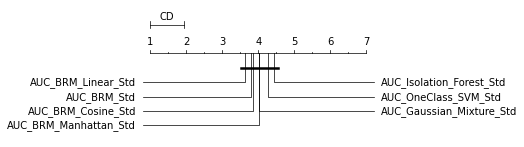

In [ ]:
import Orange

cd = Orange.evaluation.compute_CD(avranks, final_df.shape[0])
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
plt.show();